# Todo

> Extract only a portion of each exposure

>> Must write a function that takes only data from a particular region in u,v

> Figure out how to decompose data into cross/along wind components

> Write a kernel that isn't isotropic and set independent length scales for cross/along wind component

> See Tiwari (2018) for faster methods of drawing from posterior/prior distribution.

Todo for Gary:

> Continue with MCMC to tune parameters

> Use kernel that looks like:

\begin{equation}
K(\vec{x_1}, \vec{x_2}) = \sigma_{signal} * exp(-(\frac{(x_1^1 - x_2^1)^2}{l_{xx}} + \frac{(x_1^2 - x_2^2)^2}{l_{yy}} + \frac{(x_1^1 - x_2^1)(x_1^2 - x_2^2)}{l_{xy}}))
\end{equation}

for

\begin{equation}
\vec{x_{\alpha}} = (x_{\alpha}^1, x_{\alpha}^2)
\end{equation}

> Try using only dx (instead of both dx and dy) just to test things out

> Make a summary function in GPR that makes all the plots and prints all the relevant info

In [1]:
from time import time
import numpy as np
import astropy.units as u
import astropy.constants as c
import astropy.io.fits as pf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import gpr
import mcmc
import forAustin as fa

In [2]:
datafile = '/data4/paper/fox/DES/austinFull.fits'
nExposure = 500
# sample = np.array([-0.5, 0, 0, 0.5])
GP = gpr.GPR(datafile, nExposure, sample=None, verbose=True, random_state=0)

Extracting exposure from fits file...
Filename: /data4/paper/fox/DES/austinFull.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  Exposures     1 BinTableHDU     47   2820R x 19C   [1D, 1D, 4A, 1D, 8A, 1D, 1J, 1J, 1D, 1D, 8A, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  2  RESIDUALS     1 BinTableHDU     25   73818788R x 8C   [I, J, D, D, D, D, D, L]   

Extracting exposure data...
Splitting data into training and testing sets...
Generating white noise covariance function...


In [7]:
var_s = 100
sigma_x = ((5 * u.arcmin).to(u.deg)).value
sigma_y = sigma_x
phi = (0 * u.deg).to(u.rad).value
theta = (var_s, sigma_x, sigma_y, phi)
GP.fit(theta)

Generating elliptical covariance function...
Solving for posterior...
Posterior found in 77.082 seconds.



Current Log Marginal Likelihood: -4682681.730315163
Standard deviation of validation residuals: dx 19.853, dy 18.528
Standard deviation of Gaussian Process residuals: dx 17.4, dy 14.121
The ratio of validation residuals over GP residuals is: dx 1.141, dy 1.312


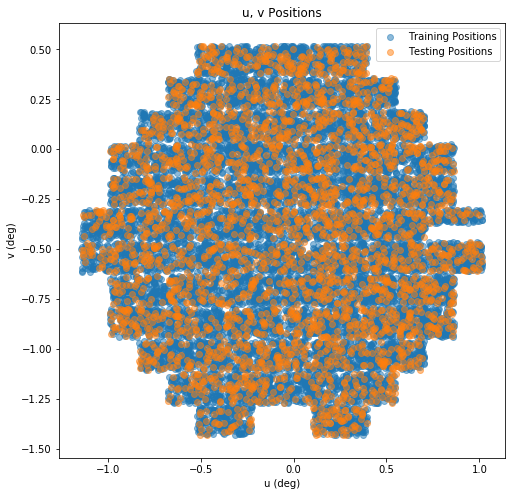

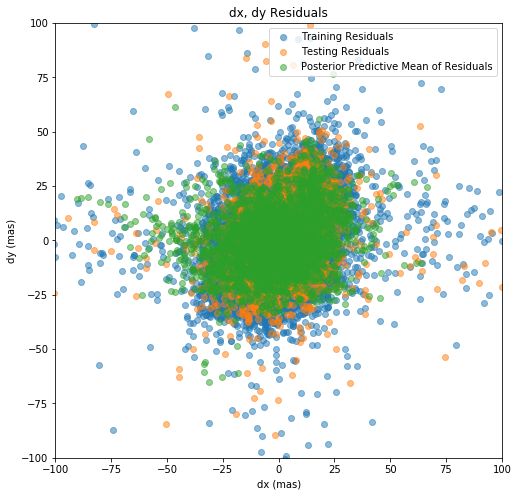

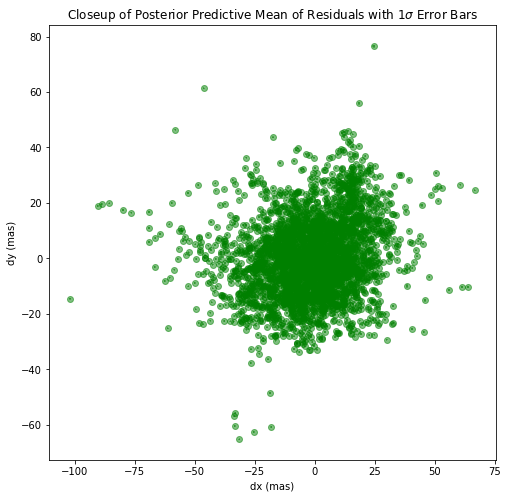

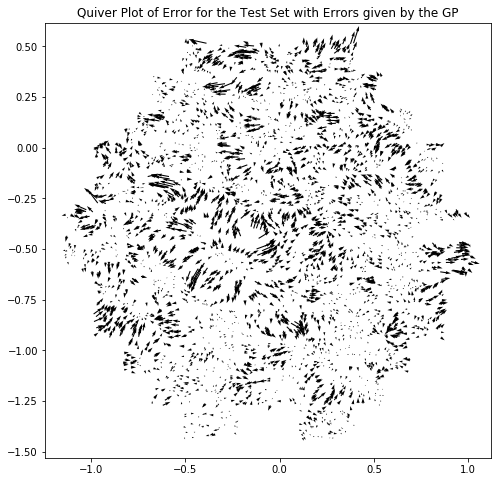

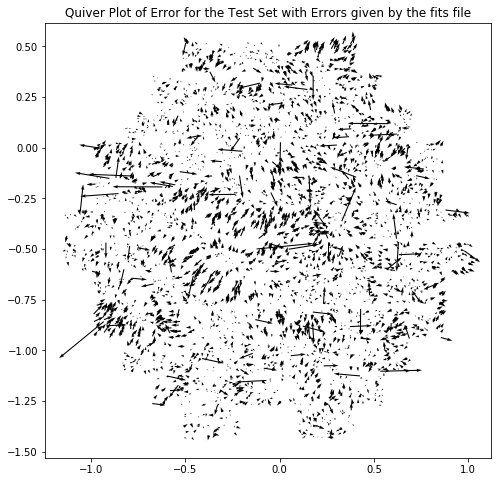

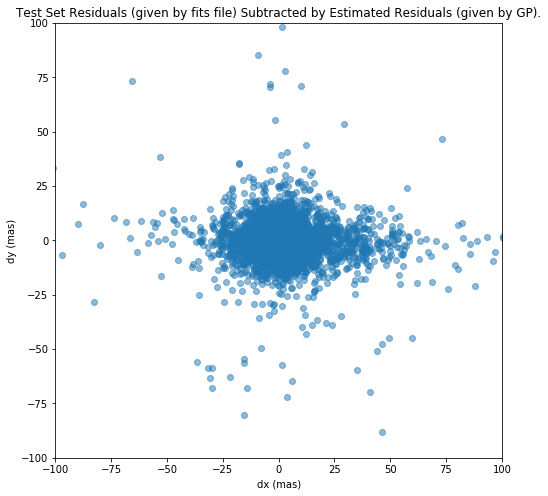

In [8]:
GP.summary()

Current Log Marginal Likelihood: -4682681.730315163
Standard deviation of validation residuals: dx 19.853, dy 18.528
Standard deviation of Gaussian Process residuals: dx 17.4, dy 14.121
The ratio of validation residuals over GP residuals is: dx 1.141, dy 1.312


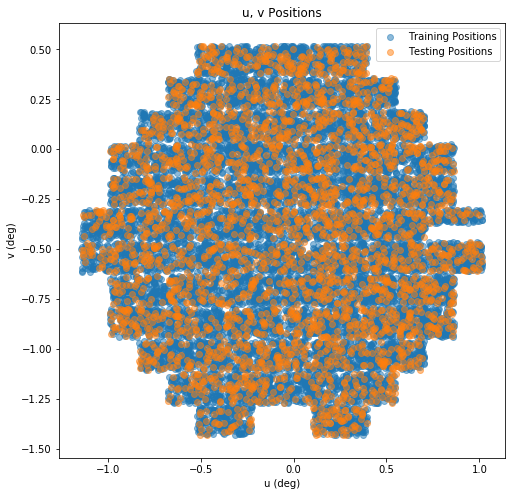

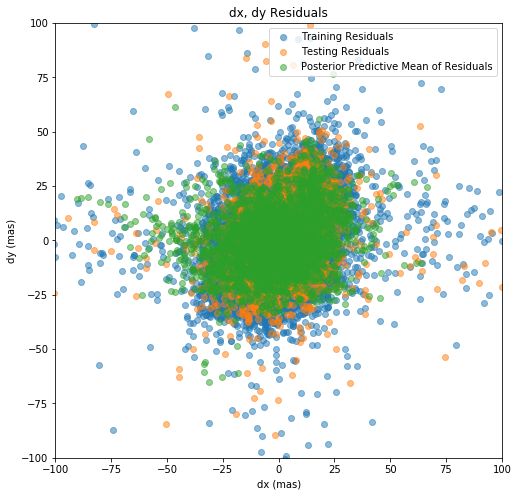

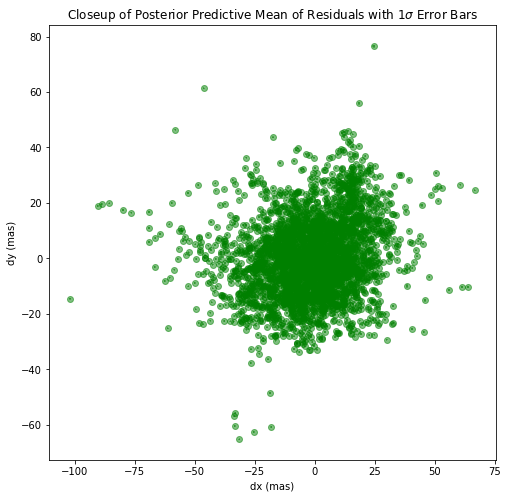

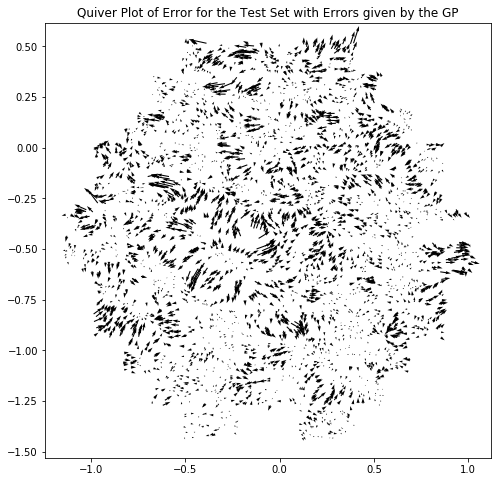

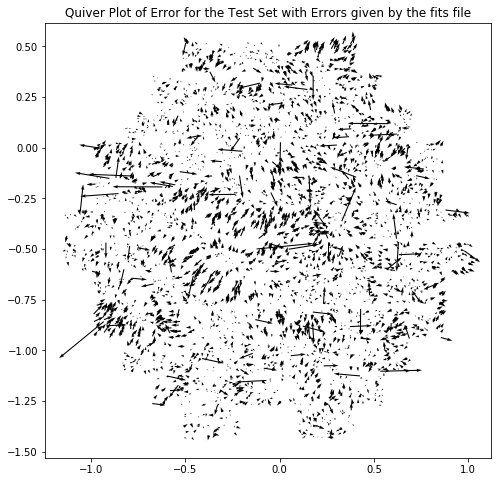

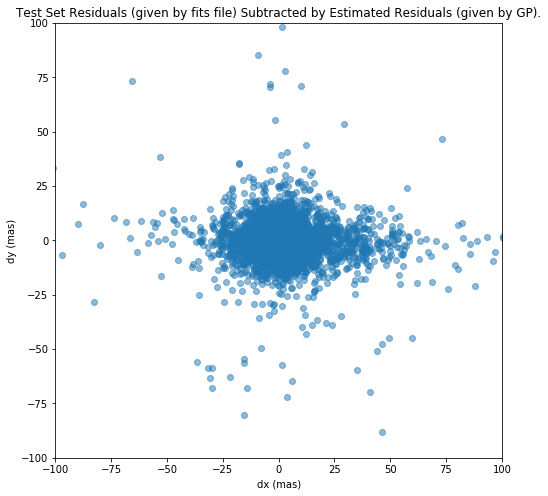

In [6]:
GP.summary()